# IAM UBA Workshop 2019

## 5. Monte Carlo

This section will demonstrate how you can run a Monte Carlo simulation of an existing model. In particular, we will run a Monte Carlo simulation of DICE2010, where we sample values for the climate sensitivity from a probability distribution.

As a first step, we are going to load a number of packages we are already familiar with, plus the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package, which contains definitions for a large number of probability distributions.

In [1]:
using Distributions, DataFrames, Mimi, MimiDICE2010, VegaLite

The distribution we are going to use for climate sensitivity is a log normal distribution that is parameterized similarily to what was used in Gillingham et al. (2019). Here we plot the histogram for this particular distribution:

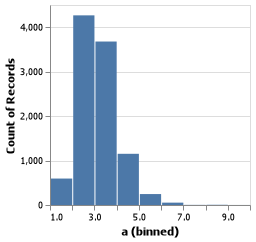

In [2]:
DataFrame(a = rand(LogNormal(1.10704, 0.264), 10000)) |> @vlplot(:bar, x={:a, bin=true}, y="count()")

To run a Monte Carlo simulation, we first create a simulation object with the `@defsim` macro that we assign to the variable `mcs`. Such a simulation object contains information about the probability distributions we want to sample from, how they should modify parameters of the model, and what output variables we want to save from the model.

In this example, we configure things such that the `t2xco2` parameter will receive values from a random variable that is log normally distributed, and we will save the `TATM` variable from the `climatedynamics` component.

In [3]:
mcs = @defsim begin
    t2xco2 = LogNormal(1.10704, 0.264)
    
    save(climatedynamics.TATM)
end

SimulationDef{MCSData}
  rvdict:
    t2xco2!1: RandomVariable{LogNormal{Float64}}
  translist:
    TransformSpec(:t2xco2, :(=), :t2xco2!1, Any[])
  savelist:
    

MCSData()

(:climatedynamics, :TATM)
  nt_type: NamedTuple{(:t2xco2!1,),Tuple{Float64}}


Next we get a normal model that will be the basis for our Monte Carlo simulation:

In [4]:
m = MimiDICE2010.get_model()

9-component Mimi.Model:
  grosseconomy::MimiDICE2010.grosseconomy
  emissions::MimiDICE2010.emissions
  co2cycle::MimiDICE2010.co2cycle
  radiativeforcing::MimiDICE2010.radiativeforcing
  climatedynamics::MimiDICE2010.climatedynamics
  sealevelrise::MimiDICE2010.sealevelrise
  damages::MimiDICE2010.damages
  neteconomy::MimiDICE2010.neteconomy
  welfare::MimiDICE2010.welfare


We can now run this model `m` as a Monte Carlo simulation by also passing the simulation definition to `run` and also specifying how many runs we want to perform, in this example 1000 runs. Note that we store the results from the `run` call in a variable called `sim_results`:

In [5]:
sim_results = run(mcs, m, 1000)

Running 1000 trials for 1 scenarios...100%|█████████████| Time: 0:00:01


SimulationInstance{MCSData}
SimulationDef{MCSData}
  rvdict:
    t2xco2!1: RandomVariable{Mimi.SampleStore{Float64}}
  translist:
    TransformSpec(:t2xco2, :(=), :t2xco2!1, Any[])
  savelist:
    (:climatedynamics, :TATM)
  nt_type: NamedTuple{(:t2xco2!1,),Tuple{Float64}}
  trials: 1000
  current_trial: 1000


MCSData()

  current_data: (t2xco2!1 = 5.666998874581484,)
  1 models
  1 results dicts


The easiest way to explore the results of a Monte Carlo simulation is to call the `explore` function on the simulation result:

In [6]:
explore(sim_results);

One can also access the full Monte Carlo results for any variable that was saved with the usual indexing syntax that we already know from the deterministic case:

In [7]:
sim_results[:climatedynamics, :TATM]

,time,TATM,trialnum
,Int64,Float64⍰,Int64
1,2005,0.83,1
2,2015,0.98,1
3,2025,1.35015,1
4,2035,1.69782,1
5,2045,2.02335,1
6,2055,2.32627,1
7,2065,2.60669,1
8,2075,2.86545,1
9,2085,3.10402,1


We will next use the package [Query.jl](https://github.com/queryverse/Query.jl) to manipulate the results from our Monte Carlo runs and then visualize them with [VegaLite.jl](https://github.com/queryverse/VegaLite.jl). [Query.jl](https://github.com/queryverse/Query.jl) is a package similar to R's dplyr, just for Julia.

In [8]:
using Query

In particular, here we filter the table that was written for the `TATM` variable to only include values for the yar 2095, and then plot a histogram of those values, namely a histogram for the temperature increase in the year 2095 that our Monte Carlo simulation created.

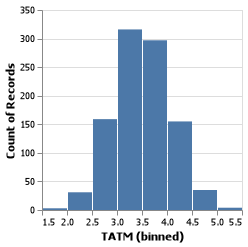

In [9]:
sim_results[:climatedynamics, :TATM] |> @filter(_.time==2095) |> @vlplot(:bar, x={:TATM, bin=true}, y="count()")

We can also use simulation definitions that are fully specified in the model package. For exmaple, PAGE09 has a full uncertainty specification out-of-the-box. In the following example we will use that to run a Monte Carlo simulation of PAGE.

First we load PAGE:

In [10]:
using MimiPAGE2009

Next we load the simulation definition from the PAGE package by calling the `getsim` function in that package. This essentially replaces the `@defsim` call we used above, and instead returns the uncertainty specification that the model developers for PAGE created:

In [11]:
msc_page = MimiPAGE2009.getsim();

The remaining steps are the same as in the previous example:

In [12]:
m_page = MimiPAGE2009.get_model();

In [13]:
sim_res_page = run(msc_page, m_page, 1_000);

Running 1000 trials for 1 scenarios...100%|█████████████| Time: 0:00:06


In [14]:
explore(sim_res_page);